# Quality assurance and quality control

## WAFS

In [176]:
%%capture
import glob
import os
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import xarray as xr
from metpy.units import units

sys.path.insert(1, "/Users/lukeconibear/repos/wxapps/")

from apps.wafs.src.wafs import utils, wafs

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["Computer Modern Roman"],
        "axes.grid": False,
        "savefig.dpi": 700,
        "figure.figsize": [8, 6],
        "font.size": 14,
    }
)
plt.style.use(["seaborn-colorblind"])
xr.set_options(display_expand_data=False)

In [137]:
batch_timestamps = pd.date_range(start="2022-05-02", end="2022-06-30", freq="6H")
filename_variable = "Wind_temp"
data_variables = [
    "air_temperature_aviation",
    "wind_speed_aviation",
    "wind_direction_aviation",
]

In [81]:
approximate_altitude_hpa_vs_feet = {}
for pressure_hpa in ds_wind_temp.isobaricInhPa.values:
    height_pressure_feet_rounded = round(
        mpcalc.pressure_to_height_std(pressure_hpa * units("hPa"))
        .to(units("ft"))
        .magnitude,
        -3,
    )
    approximate_altitude_hpa_vs_feet[str(int(pressure_hpa))] = str(
        int(height_pressure_feet_rounded)
    )

indices_hpa = {}
for pressure_hpa in ds_wind_temp.isobaricInhPa.values:
    index_hpa = np.argwhere(ds_wind_temp.isobaricInhPa.values == pressure_hpa)
    indices_hpa[str(int(pressure_hpa))] = str(int(index_hpa))

indices_feet = {}
for altitude_feet in ds_wind_temp_regridded.lev.values:
    index_feet = np.argwhere(ds_wind_temp_regridded.lev.values == altitude_feet)
    indices_feet[str(int(altitude_feet))] = str(int(index_feet))

In [83]:
threshold_ratios = [round(ratio, 1) for ratio in np.linspace(0.1, 0.5, 5)]
threshold_diffs = [int(diff) for diff in np.linspace(1, 5, 5)]

In [126]:
overall_threshold_percentages_of_ratios_within = {
    f"{data_variable}": {
        str(threshold_ratio): [] for threshold_ratio in threshold_ratios
    }
    for data_variable in data_variables
}
overall_threshold_percentages_of_diffs_within = {
    f"{data_variable}": {str(threshold_diff): [] for threshold_diff in threshold_diffs}
    for data_variable in data_variables
}

In [127]:
def evaluate_forecast(forecast_time):
    filename = (
        f"/Users/lukeconibear/repos/pangeo_tools/wafs/raw_data/"
        f"{filename_variable}/{batch_timestamp.year}{batch_timestamp.month:02}"
        f"{batch_timestamp.day:02}_{batch_timestamp.hour:02}00"
        f"f{forecast_time.hour:02}.grib2"
    )
    ds_raw_grib = wafs.open_grib_dataset(
        filename,
        height_dimension="isobaricInhPa",
    )
    u_wind_component = ds_raw_grib["u"] * units("m/s")
    v_wind_component = ds_raw_grib["v"] * units("m/s")
    wind_speed_aviation = mpcalc.wind_speed(u_wind_component, v_wind_component)
    wind_direction_aviation = mpcalc.wind_direction(u_wind_component, v_wind_component)
    air_temperature_aviation = ds_raw_grib["t"].metpy.convert_units("degC")

    ds_wind_temp = xr.combine_by_coords(
        [
            xr.Dataset(
                {
                    "air_temperature_aviation": air_temperature_aviation.metpy.dequantify()
                }
            ),
            xr.Dataset({"wind_speed_aviation": wind_speed_aviation.metpy.dequantify()}),
            xr.Dataset(
                {"wind_direction_aviation": wind_direction_aviation.metpy.dequantify()}
            ),
        ]
    )
    ds_wind_temp_converted = wafs.convert_pressure_to_height(
        ds_wind_temp,
        old_height_dimension="isobaricInhPa",
        new_height_dimension="lev",
        old_units="hPa",
        new_units="ft",
    )
    flight_altitudes = list(range(3_000, 56_000, 1_000))
    ds_wind_temp_interpolated = wafs.interpolate_to_flight_altitudes(
        ds_wind_temp_converted,
        flight_altitudes,
    )

    threshold_percentages_of_diffs_within_data_variables = {}
    threshold_percentages_of_ratios_within_data_variables = {}

    for data_variable in data_variables:
        threshold_percentages_of_ratios_within = {
            str(threshold_ratio): [] for threshold_ratio in threshold_ratios
        }
        threshold_percentages_of_diffs_within = {
            str(threshold_diff): [] for threshold_diff in threshold_diffs
        }

        for altitude_hpa, altitude_feet in approximate_altitude_hpa_vs_feet.items():
            index_hpa = int(indices_hpa[altitude_hpa])
            index_feet = int(indices_feet[altitude_feet])

            actual_diff = np.subtract(
                ds_wind_temp[data_variable].isel(isobaricInhPa=index_hpa),
                ds_wind_temp_interpolated[data_variable].isel(lev=index_feet),
            )

            actual_ratio = np.divide(
                ds_wind_temp[data_variable].isel(isobaricInhPa=index_hpa),
                ds_wind_temp_interpolated[data_variable].isel(lev=index_feet),
            )

            for threshold_ratio in threshold_ratios:
                actual_ratio_within = actual_ratio.where(
                    cond=np.abs(actual_ratio) > (1.0 - threshold_ratio)
                ).where(cond=np.abs(actual_ratio) < (1.0 + threshold_ratio))

                threshold_percentage_of_values_within = 1 - (
                    actual_ratio_within.isnull().sum().values
                    / (
                        actual_ratio_within.longitude.shape[0]
                        * actual_ratio_within.latitude.shape[0]
                    )
                )

                threshold_percentages_of_ratios_within[str(threshold_ratio)].append(
                    threshold_percentage_of_values_within
                )

            for threshold_diff in threshold_diffs:
                actual_diff_within = actual_diff.where(
                    cond=np.abs(actual_diff) < threshold_diff
                )

                threshold_percentage_of_diffs_within = 1 - (
                    actual_diff_within.isnull().sum().values
                    / (
                        actual_diff_within.longitude.shape[0]
                        * actual_diff_within.latitude.shape[0]
                    )
                )

                threshold_percentages_of_diffs_within[str(threshold_diff)].append(
                    threshold_percentage_of_diffs_within
                )

        threshold_percentages_of_diffs_within_data_variables[
            data_variable
        ] = threshold_percentages_of_diffs_within
        threshold_percentages_of_ratios_within_data_variables[
            data_variable
        ] = threshold_percentages_of_ratios_within

    return (
        threshold_percentages_of_diffs_within_data_variables,
        threshold_percentages_of_ratios_within_data_variables,
    )

In [ ]:
%%capture
for batch_timestamp in batch_timestamps:
    forecast_times = [batch_timestamp + pd.to_timedelta(hour) for hour in ["6H", "9H"]]
    for forecast_time in forecast_times:
        print(forecast_time.isoformat().replace(":00:00", ""))
        try:
            (
                threshold_percentages_of_diffs_within_data_variables,
                threshold_percentages_of_ratios_within_data_variables,
            ) = evaluate_forecast(forecast_time)
        except:
            FileNotFoundError

        for data_variable in data_variables:
            for threshold_ratio in overall_threshold_percentages_of_ratios_within[
                data_variable
            ].keys():
                overall_threshold_percentages_of_ratios_within[data_variable][
                    threshold_ratio
                ].append(
                    threshold_percentages_of_ratios_within_data_variables[
                        data_variable
                    ][threshold_ratio]
                )

In [140]:
for data_variable in data_variables:
    print(data_variable)
    for (
        threshold_ratio,
        threshold_values,
    ) in overall_threshold_percentages_of_ratios_within[data_variable].items():
        print(
            (
                f"Percentage of ratios within {100 * float(threshold_ratio):0.0f}%:"
                f" {100 * np.mean(threshold_values):0.0f}%"
            )
        )

    print()

air_temperature_aviation
Percentage of ratios within 10%: 95%
Percentage of ratios within 20%: 98%
Percentage of ratios within 30%: 99%
Percentage of ratios within 40%: 99%
Percentage of ratios within 50%: 99%

wind_speed_aviation
Percentage of ratios within 10%: 98%
Percentage of ratios within 20%: 99%
Percentage of ratios within 30%: 100%
Percentage of ratios within 40%: 100%
Percentage of ratios within 50%: 100%

wind_direction_aviation
Percentage of ratios within 10%: 97%
Percentage of ratios within 20%: 98%
Percentage of ratios within 30%: 99%
Percentage of ratios within 40%: 99%
Percentage of ratios within 50%: 99%



In [177]:
%%capture
u_ag, v_ag = mpcalc.ageostrophic_wind(
    height=ds_raw_grib["gh"],
    u=ds_raw_grib["u"],
    v=ds_raw_grib["v"],
    latitude=ds_raw_grib.latitude,
    x_dim=-1,
    y_dim=-2,
)

In [173]:
wind_speed_diff_from_geostrophic = mpcalc.wind_speed(u_ag, v_ag)

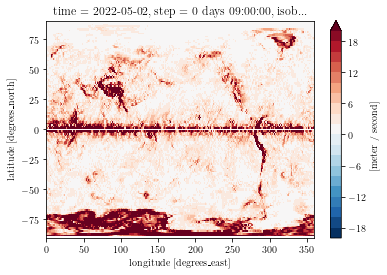

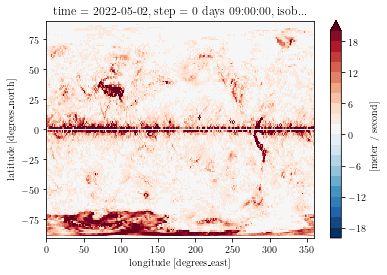

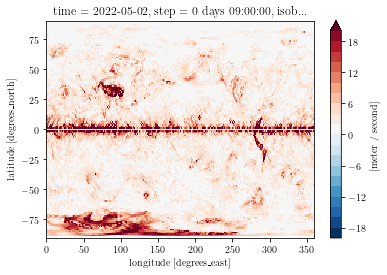

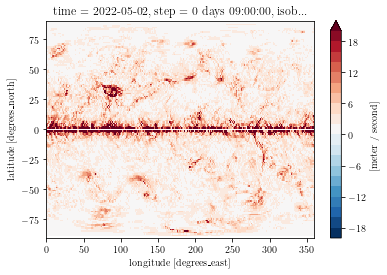

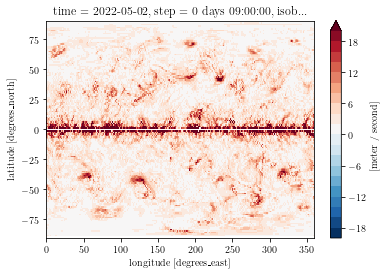

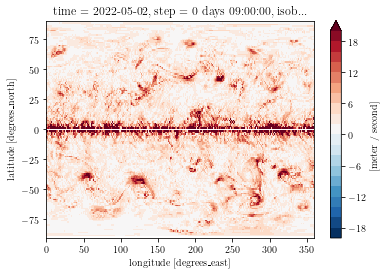

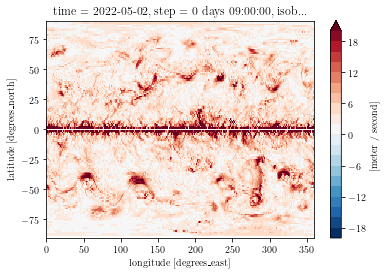

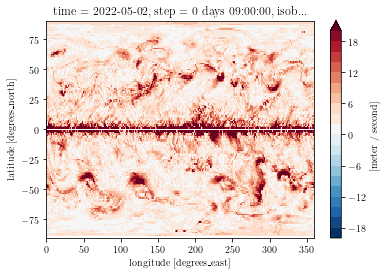

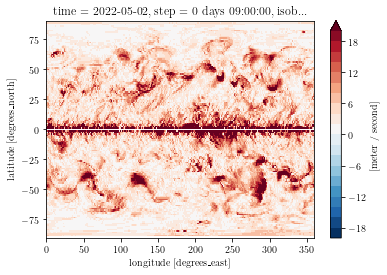

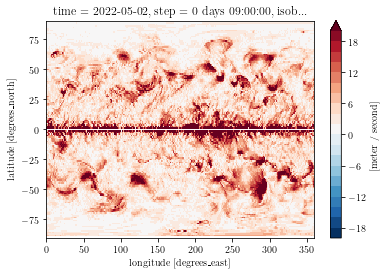

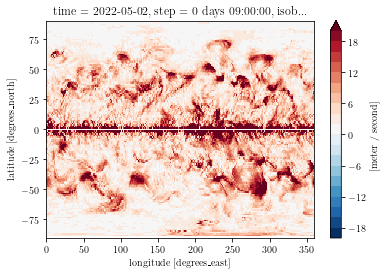

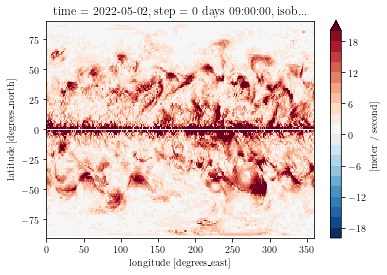

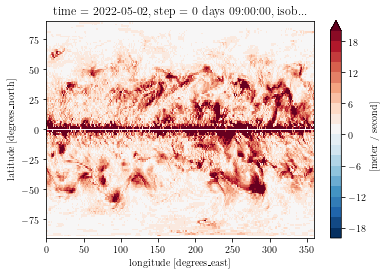

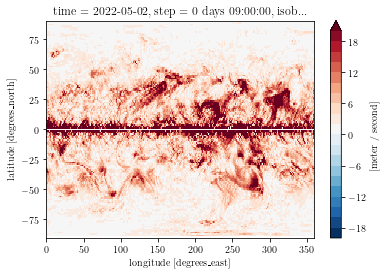

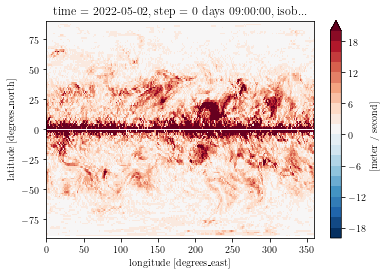

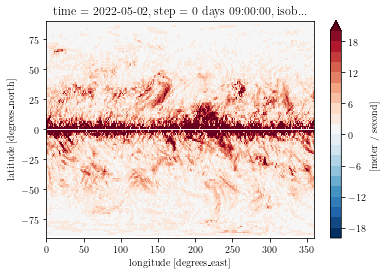

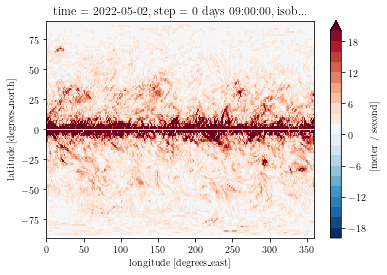

In [174]:
for lev in range(len(diff.isobaricInhPa.values)):
    wind_speed_diff_from_geostrophic.isel(isobaricInhPa=lev).plot(
        levels=np.linspace(-20, 20, 21),
    )
    plt.show()